In [3]:
# Necessary imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Unit conversions
ps = 10**-12    # picoseconds unit
nm = 10**-9     # nanometers unit
um = 10 ** -6   # micrometer unit
    
# Physical parameters
RefractiveIndex = 1                         # unitless
speed_of_light = 299792458                  # in m/s
wavelength = 351 * nm                       # chosen wavelength
R = 25 * um                                 # radius of laser
E_L = 10 * (10 ** -6)                       # in joules laser energy (10 mu joules)
Area_L = np.pi * R **2                      # area of laser
T_laser = 100 * ps                          # laser pulse time
I_0 = E_L / (Area_L * T_laser)              # laser intensities (SI unit is Joules/(m**2) * s )
permittivity_free_space = 8.85418782 * 10 **-12
E_0 = np.sqrt( (2 * I_0) / (speed_of_light * RefractiveIndex * permittivity_free_space)) # Electric field SI unit is voltage / m

# time-step size “dt” is strictly controlled by Courant–Friedrichs–Lewy (CFL) condition 
#so that the wave propagation distance within a allowed time-step size cannot exceed the grid size “dx”.
CFL = 0.5
delta_x = 0.05 * wavelength
delta_t = CFL * delta_x / speed_of_light    # time related time-step

# Physics formulas
frequency = speed_of_light/wavelength       # in Hertz
angular_frequency = 2 * np.pi * frequency   # in Hertz
wavenumber = (2 * np.pi) / wavelength       # wave number 'k' will be imaginary part in the coming days (when we do it correctly)
period = wavelength / speed_of_light        # wave period (can also be calculated with 1/f)

# Grid and time parameters
lambda_mult = 10                    # represents number of cycles
T = lambda_mult * period            # modeling time
n_timestep = int(T/delta_t)         # n time step

L = wavelength * lambda_mult        # 'length' of simulation
n_cells = int(L/delta_x)            # number of cells (can also think of as number of grid points)

## Modeling the damping wave

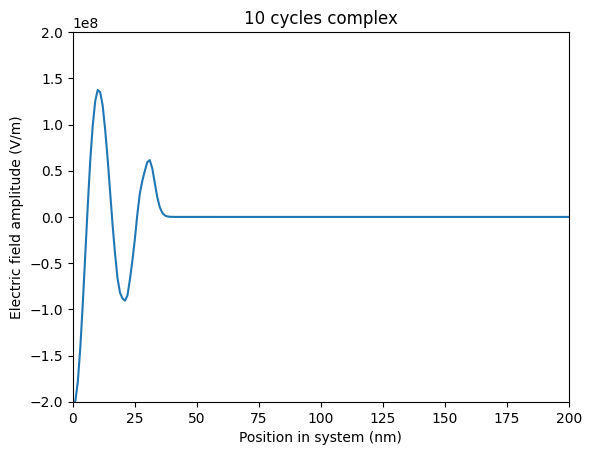

In [89]:
def complex_decaying_wave_soln(n_real, n_imaginary):

    # defining complex index of refraction (no imaginary yet)
    complex_refractive_index = complex(n_real, n_imaginary)
    complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

    x = []  # spatial domain (can also think of as coordinates of grid points)
    t = []  # time domain

    # Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
    # The ghost cells are there so that in the matrix we can access all indeces
    # To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
    for i in range(-2, n_cells + 3):
        x.append(delta_x * (i + 0.5))

    for i in range(-2, n_timestep + 3):
        t.append(delta_t * (i + 0.5))

    x = np.array(x)
    t = np.array(t)

    E_complex = 1j * np.zeros((len(t), len(x))) # initializing imaginary matrix of dimensions (t, x)
    r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

    # These loops will go through the grid. We start at 1 so as to not calculate the
    # value when the a time or spatial point is equal to 0.
    index = 0
    for n in range(1, (len(t) - 3)*1 + 0):
        t_sim = t[n] # in seconds

        # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
        # Making sin zero because it is imaginary component
        cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_0_t_nm1 = 0

        cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_1_t_nm1 = 0

        # Initial conditions in time:
        E_complex[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
        E_complex[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)


        # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
        # Making sin zero because it is imaginary component
        cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_0_t_n = 0

        cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_1_t_n = 0

        # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
        E_complex[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
        E_complex[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)

        # We have no laser on the left, so boundary conditions are just 0
        E_complex[n, -1] = complex(0)
        E_complex[n, -2] = complex(0)

        precision_num = 10
        for i in range(2, len(x) - 3):

            # explicit scheme
            E_complex[n+1, i] = np.exp(-complex_wavenumber.imag * x[i]) * ( (r_const_complex.real) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ) - ( -2*E_complex[n, i] + E_complex[n-1, i] ) )

            # this if block constrains the wave to inside our physical bounds
            if (True) and abs(E_complex[n+1, i])/abs(E_0) > 1:
                E_complex[n+1, i] = E_0 * np.sign(E_complex[n, i])

            index += 1
            
    return E_complex, x, t

E_complex_non_damped = complex_decaying_wave_soln(1, 0)

# Adding imaginary to damp wave
# re-defining complex index of refraction (adding imaginary part to force damping using analytical solution)
n_real = 1
n_i = 0.125
complex_refractive_index = complex(n_real, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index
E_complex_data = E_complex_non_damped[0]
E_complex_data_xdata = E_complex_non_damped[1]
E_complex_data_tdata = E_complex_non_damped[2]

format_title = "{} cycles complex".format(lambda_mult)
plt.title(format_title)
plt.xlabel("Position in system (nm)") # in entire simulation domain. Units of 10 ** -9 meters in SI units
plt.ylabel("Electric field amplitude (V/m)") # SI unit of volts / m
# Setting the x-axis to 1-10
# and y-axis to 1-15
plt.axis([0, 200, -2*(10**8), 2*(10**8)])
# plt.plot(np.exp(-complex_wavenumber.imag * E_complex_data_xdata) * E_complex_data[int(int(E_complex_data.shape[0]/lambda_mult) * lambda_mult), :].real)
plt.plot(np.exp(-complex_wavenumber.imag * E_complex_data_xdata) * E_complex_data[int(int(70/lambda_mult) * lambda_mult), :].real)
plt.show()

In [4]:
def complex_decaying_wave_soln(n_real, n_imaginary):

    # defining complex index of refraction (no imaginary yet)
    complex_refractive_index = complex(n_real, n_imaginary)
    complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index

    x = []  # spatial domain (can also think of as coordinates of grid points)
    t = []  # time domain

    # Creating arrays for the spatial and time domains. Starting at -2 in order to create ghost cells. And ending with + 3 for the same reason
    # The ghost cells are there so that in the matrix we can access all indeces
    # To append, using formula Dr. Woo gave me: X_i = delta_x(i + 1/2)
    for i in range(-2, n_cells + 3):
        x.append(delta_x * (i + 0.5))

    for i in range(-2, n_timestep + 3):
        t.append(delta_t * (i + 0.5))

    x = np.array(x)
    t = np.array(t)

    E_complex = 1j * np.zeros((len(t), len(x))) # initializing imaginary matrix of dimensions (t, x)
    r_const_complex = ( (delta_t/delta_x) * (speed_of_light/complex_refractive_index) ) ** 2 # our parameter

    # These loops will go through the grid. We start at 1 so as to not calculate the
    # value when the a time or spatial point is equal to 0.
    index = 0
    for n in range(1, (len(t) - 3)*1 + 0):
        
        laserI_INC   = pulse_IN[time_step,1]      # W/m^2
        laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
        time_current = pulse_IN[time_step,0]*ps   # s
        time_next    = pulse_IN[time_step+1,0]*ps # s
        ite_max      = int((time_next - time_current)/dt)
        
        
        t_sim = t[n] # in seconds
        
        for ite in range(ite_max):
        
        # wont need the three, just one (zero)
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = 0 #laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        
        # mesh to store variable to save inside this long array.
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m (initial position)
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = 0 #laserI_probe # W/m^2

        # Defning cos and sin terms for wave to later be turned into complex numbers for t_nm1
        # Making sin zero because it is imaginary component
        cos_term_0_t_nm1 = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_0_t_nm1 = 0

        cos_term_1_t_nm1 = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n-1]) + np.pi/2)
        sin_term_1_t_nm1 = 0

        # Initial conditions in time:
        E_complex[n-1, 0] = complex(cos_term_0_t_nm1, sin_term_0_t_nm1)
        E_complex[n-1, 1] = complex(cos_term_1_t_nm1, sin_term_1_t_nm1)


        # Defning cos and sin terms for wave to later be turned into complex numbers for t_n
        # Making sin zero because it is imaginary component
        cos_term_0_t_n = E_0 * np.cos((wavenumber * x[0]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_0_t_n = 0

        cos_term_1_t_n = E_0 * np.cos((wavenumber * x[1]) - (angular_frequency * t[n]) + np.pi/2)
        sin_term_1_t_n = 0

        # Instantenously defining the boundary conditions/values of ghost cells on the RIGHT:
        E_complex[n, 0] = complex(cos_term_0_t_n, sin_term_0_t_n)
        E_complex[n, 1] = complex(cos_term_1_t_n, sin_term_1_t_n)

        # We have no laser on the left, so boundary conditions are just 0
        E_complex[n, -1] = complex(0)
        E_complex[n, -2] = complex(0)

        precision_num = 10
        
        # x loop
        for i in range(2, len(x) - 3):

            # explicit scheme
            E_complex[n+1, i] = np.exp(-complex_wavenumber.imag * x[i]) * ( (r_const_complex.real) * ( E_complex[n, i+1] - 2*E_complex[n, i] + E_complex[n, i-1] ) - ( -2*E_complex[n, i] + E_complex[n-1, i] ) )

            # this if block constrains the wave to inside our physical bounds
            if (True) and abs(E_complex[n+1, i])/abs(E_0) > 1:
                E_complex[n+1, i] = E_0 * np.sign(E_complex[n, i])

            index += 1
            
    return E_complex, x, t

E_complex_non_damped = complex_decaying_wave_soln(1, 0)

# Adding imaginary to damp wave
# re-defining complex index of refraction (adding imaginary part to force damping using analytical solution)
n_real = 1
n_i = 0.125
complex_refractive_index = complex(n_real, n_i)
complex_wavenumber = (angular_frequency / speed_of_light) * complex_refractive_index
E_complex_data = E_complex_non_damped[0]
E_complex_data_xdata = E_complex_non_damped[1]
E_complex_data_tdata = E_complex_non_damped[2]

format_title = "{} cycles complex".format(lambda_mult)
plt.title(format_title)
plt.xlabel("Position in system (nm)") # in entire simulation domain. Units of 10 ** -9 meters in SI units
plt.ylabel("Electric field amplitude (V/m)") # SI unit of volts / m
plt.plot(np.exp(-complex_wavenumber.imag * E_complex_data_xdata) * E_complex_data[int(int(E_complex_data.shape[0]/lambda_mult) * lambda_mult), :].real)
plt.show()

IndentationError: expected an indented block after 'for' statement on line 39 (1474723880.py, line 42)

In [5]:
#### MESH AND CFL ####
Thickness = 1000 * nm
Nz = int(Thickness*um/wavelength_351nm) # nm
dz = wavelength_351nm # nm
dt = dz/lightSpeed*1 # s
# 
#laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination (relaxation)
nc_351nm     = get_nc(wavelength_351nm) # (1/m^3)
Ns_zone  = 6
Ns_edge  = 4
var_zone = np.zeros([Nz,Ns_zone])

n_0 = 0     # 1/m^3 
n_1 = 0     # 1/m^3 
n_2 = 0     # 1/m^3 
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

# FOR ME, JUST SAVE ne, Te and Ti because ne split into diff components
var_zone[:,0] = n_e # 1/m^3 
var_zone[:,1] = Te  # J
var_zone[:,2] = Ti  # J

t_start_wall = timeCheck.time() # simulation start points
hist         = []

pulse_IN = laser_pulse # initialize laser pulse
#pulse_IN_Imax_TimePs = pulse_1_Imax_TimePs
   
time         = 0                         # s
time_step    = 0
for time_step in range(pulse_IN.shape[0]-1):

    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ps   # s
    time_next    = pulse_IN[time_step+1,0]*ps # s
    ite_max      = int((time_next - time_current)/dt)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('laserI_INC   = ',"{:.3e}".format(laserI_INC),' W/m^2')
    print('Te_IN/eV,  Ti_IN/eV  = ',"{:.3e}".format(var_zone[0,3]/eV),
          "{:.3e}".format(var_zone[0,4]/eV))
    print('Te_OUT/eV, Ti_OUT/eV = ',"{:.3e}".format(var_zone[-1,3]/eV),
          "{:.3e}".format(var_zone[-1,4]/eV))    
    print('ite_max      = ',ite_max) 
    
    for ite in range(ite_max):
        
        # wont need the three, just one (zero)
        n_fe_max = np.max(var_zone[:,0]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = 0 #laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        
        # mesh to store variable to save inside this long array.
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m (initial position)
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = 0 #laserI_probe # W/m^2
        
        # x or space for loop, other one was time for loop
        for zone in range(1,Nz+1):
            # create a square zone
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            # again, only need ne not n1, n2, n3
            n_e = var_zone[i_zone,0] # 1/m^3
            Te  = var_zone[i_zone,1] # J
            Ti  = var_zone[i_zone,2] # J  
            
            # ne only
            n_fe  = n_e          # 1/m^3
            beta  = (n_vb - n_fe)/n_vb # no unit
            # ne_old
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            vc = get_vc(Te,Ti,n_fe,ni,rho)             # 1/s
            #####################################
            n       = get_n(n_fe,omega_800nm) # unitless (critical density CHANGE TO 351 nm)  
            #n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            #laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_800nm,Eg_Sapphire) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s DO NOT NEED!!
            #WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_800nm,laserE,n)
            #dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_Sapphire
            #dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_Sapphire
            laserI_new       = laserI       + dz * dIdz
            #laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = 0 #laserI_probe_new         # W/m^2  WE HAVE NO PROBE BEAM
            
            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            # ne for me!
            var_zone[i_zone,0] = n_e_new # 1/m^3   
            
            #######################
            # Thermodynamics (calculates transfer from C_ve from source laser?)
            #######################
            #####################################
            vc = get_vc(Te,Ti,n_fe_new,ni,rho) # 1/s
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_351nm,laserE,n)
            Ce = get_Ce(n_fe_new,Te) # 1/m^3
            Ci = get_Ci(Ti,ni) # 1/m^3 
            G  = get_G(Ce,vc)  # 1/m^3/s
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3
            Qi = G*(Te-Ti)                             # J/s/m^3
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV 
            
            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            #laserI_probe = laserI_probe_new
            
            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('laserI = ',"{:.3e}".format(laserI))
                print('omega_355nm = ',"{:.3e}".format(omega_800nm))
                print('Eg_CH = ',"{:.3e}".format(Eg_Sapphire))
                print('beta, WPI = ',beta, WPI)
                print('source = ',source)
                print('n_0_new, n_1_new, n_2_new = ',n_0_new, n_1_new, n_2_new)
                print('dn_fe = ',"{:.3e}".format(dn_fe))
                print('Qe = ',"{:.3e}".format(Qe))
                print('Qi = ',"{:.3e}".format(Qi))
                print('vc = ',"{:.3e}".format(vc))
                print('dUdt_JH = ',dUdt_JH)
                print('Ce = ',"{:.3e}".format(Ce))
                print('ni = ',"{:.3e}".format(ni))
                print('Ci/ni = ',"{:.3e}".format(Ci/ni))
                print('G = ',"{:.3e}".format(G))
                break

            if (laserI_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_351nm) :
                print('negative n_fe exceed nc detected, STOP')
                break
                
            if 1 : 
                print('time_ps,zone,I/I0',int(time/ps),zone,"{:.3e}".format(laserI/laserI_INC))   
                print('laserI               = ',"{:.3e}".format(laserI))
                print('n_fe_new [1/m^3]     = ',"{:.3e}".format(n_fe_new))
                print('n_fe [1/m^3]         = ',"{:.3e}".format(n_fe))
                print('W_PI [1/s/m^3]       = ',"{:.3e}".format(W_PI*10**6))
                print('W_PI*Eg_CH [J/s/m^3] = ',"{:.3e}".format(W_PI*10**6*Eg_Sapphire))
                print('dUdt_JH [J/s/m^3]    = ',"{:.3e}".format(dUdt_JH))
                print('vc [1/s]             = ',"{:.3e}".format(vc))
                print('omega [rad/s]        = ',"{:.3e}".format(omega_351nm))
                print('ni [1/m^3]           = ',"{:.3e}".format(ni))
                print()
                
        time = time + dt
        
    hist.append([time,
                 #laserI_probe/laserI_probe_INC,
                 laserI/laserI_INC,
                 var_zone,var_edge
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',    
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)                 

NameError: name 'wavelength_351nm' is not defined

## RE-PLOT INTENSITY OVER POSITION